In [46]:
# import os, re, and skimage packages to load images
import os
import re
from skimage import io, color
from skimage.color import rgb2gray
from skimage.io import imread

# import matplot for visualizing training results
import matplotlib.pyplot as plt  

# import keras packages to generate model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.callbacks import History
from keras import optimizers


In [2]:
'''
define import_images function to pull from directory, convert to grayscale, append to list
'''
def import_images(dir_name, images, image_names):
    for root, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                image_names.append(filename)
                
                ## read images and add to list
                image = io.imread(fname=filepath)
                image_gray = rgb2gray(image)
                images.append(image_gray)


In [50]:
'''
establish expected image parameters, training, validation locations
'''

# expected image size
img_width, img_height = 512, 512

# folder containing the images on which the network will train. The train folder 
# has two sub folders, 'yes' and 'no' needle-containing images.
train_data_dir = '../../data_full/train'

# folder containing the validation samples folder structure is same as the training folder
validation_data_dir = '../../data_full/validation'

# same for training
test_data_dir = '../../data_full/test'

# how many images to be considered for training
train_images = []
train_names = []
import_images(train_data_dir, train_images, train_names)
train_samples = len(train_images)
print(train_samples)

# how many images to be used for validation
validation_images = []
validation_names = []
import_images(validation_data_dir, validation_images, validation_names)
validation_samples = len(validation_images)
print(validation_samples)

# how many images to be used for testing
test_images = []
test_names = []
import_images(test_data_dir, test_images, test_names)
test_samples = len(test_images)
print(test_samples)

# set batch size
batch_size = 16

# how many runs will the network make over the training set before starting on validation
epoch = 100


504
63
64


In [21]:
'''
run image augmentation procedures
'''

# augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=20,
        horizontal_flip=True,
        vertical_flip = True)

# augmentation configuration for testing:
    # only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')


Found 504 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [51]:
'''
build 16-layer VGG ConvNet
'''

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(model, to_file='../../output/models/vgg16_model.png')


In [ ]:
'''
train model and generate history callback
'''

history = History()

history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_samples // batch_size,
        epochs=epoch,
        validation_data = validation_generator,
        validation_steps = validation_samples // batch_size,
        callbacks=[history])
model.save_weights('../../output/weights/vgg16_weights_Mar22-730.h5')  # always save your weights after training or during training




Epoch 1/100
31/31 [==============================] - 13s 419ms/step - loss: 0.8162 - acc: 0.6381 - val_loss: 0.6186 - val_acc: 0.6809
Epoch 2/100
31/31 [==============================] - 11s 351ms/step - loss: 0.6074 - acc: 0.6758 - val_loss: 0.6006 - val_acc: 0.6632
Epoch 3/100
31/31 [==============================] - 11s 352ms/step - loss: 0.5821 - acc: 0.6683 - val_loss: 0.6189 - val_acc: 0.6702
Epoch 4/100
31/31 [==============================] - 11s 352ms/step - loss: 0.5477 - acc: 0.6593 - val_loss: 0.5455 - val_acc: 0.6737
Epoch 5/100
31/31 [==============================] - 11s 367ms/step - loss: 0.5212 - acc: 0.6801 - val_loss: 0.6537 - val_acc: 0.6596
Epoch 6/100
31/31 [==============================] - 11s 367ms/step - loss: 0.5371 - acc: 0.6969 - val_loss: 0.5574 - val_acc: 0.6526
Epoch 7/100
31/31 [==============================] - 11s 369ms/step - loss: 0.5203 - acc: 0.7195 - val_loss: 0.6313 - val_acc: 0.6596
Epoch 8/100
31/31 [==============================] - 11s 369ms

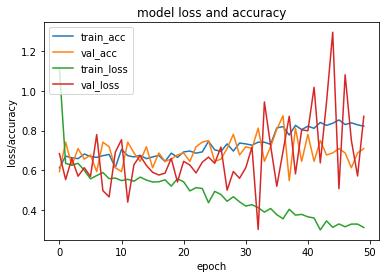

In [49]:
'''
plot training and validation loss and accuracy history
'''

fig = plt.figure(1)  

# summarize history for accuracy  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  

plt.title('model loss and accuracy')  
plt.ylabel('loss/accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')  

plt.show()  

In [44]:
# create test data generator
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (img_width, img_height),
        batch_size = 1,
        color_mode = 'grayscale',
        class_mode = 'binary',
        # this will also ensure the same order
        shuffle = False)

# run prediction generator on test dataset
probabilities=model.predict_generator(
    test_generator, 
    steps=64)

# return filenames for testing images for evaluation of predictions
image_name=test_generator.filenames
image_name

# compare predictions to ground truth and acquire overall prediction accuracy



Found 64 images belonging to 2 classes.


['0/10819.jpg',
 '0/11624.jpg',
 '0/12312.jpg',
 '0/1283.jpg',
 '0/1368.jpg',
 '0/16867.jpg',
 '0/1693.jpg',
 '0/17920.jpg',
 '0/18885.jpg',
 '0/19299.jpg',
 '0/20027.jpg',
 '0/2064.jpg',
 '0/2601.jpg',
 '0/4813.jpg',
 '0/5650.jpg',
 '0/5651.jpg',
 '0/6374.jpg',
 '0/7560.jpg',
 '0/7662.jpg',
 '0/8420.jpg',
 '0/9305.jpg',
 '1/10303.jpg',
 '1/10451.jpg',
 '1/10479.jpg',
 '1/10880.jpg',
 '1/12668.jpg',
 '1/13142.jpg',
 '1/1351.jpg',
 '1/1441.jpg',
 '1/15631.jpg',
 '1/15754.jpg',
 '1/15794.jpg',
 '1/16180.jpg',
 '1/1631.jpg',
 '1/16328.jpg',
 '1/16331.jpg',
 '1/17530.jpg',
 '1/17689.jpg',
 '1/17812.jpg',
 '1/17841.jpg',
 '1/17880.jpg',
 '1/18846.jpg',
 '1/18954.jpg',
 '1/1899.jpg',
 '1/19136.jpg',
 '1/19289.jpg',
 '1/19645.jpg',
 '1/20001.jpg',
 '1/2610.jpg',
 '1/3482.jpg',
 '1/4831.jpg',
 '1/4839.jpg',
 '1/4976.jpg',
 '1/4989.jpg',
 '1/5581.jpg',
 '1/6224.jpg',
 '1/6541.jpg',
 '1/6549.jpg',
 '1/7183.jpg',
 '1/7971.jpg',
 '1/7976.jpg',
 '1/7977.jpg',
 '1/8023.jpg',
 '1/8928.jpg']